In [1]:
from sklearn import random_projection
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

class RandomProjectionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, n_projections=10, n_components='auto', random_state=None):
        self.base_classifier = base_classifier
        self.n_projections = n_projections
        self.n_components = n_components
        self.random_state = random_state
        self.classifiers = []
        self.projections = []

    def fit(self, X, y):
        # Create and train multiple classifiers on different random projections
        for _ in range(self.n_projections):
            rp = random_projection.GaussianRandomProjection(n_components=self.n_components, random_state=self.random_state)
            X_proj = rp.fit_transform(X)
            clf = clone(self.base_classifier)
            clf.fit(X_proj, y)
            self.classifiers.append(clf)
            self.projections.append(rp)
        return self

    def predict(self, X):
        # Collect predictions from all classifiers and use majority voting
        predictions = np.array([clf.predict(rp.transform(X)) for clf, rp in zip(self.classifiers, self.projections)])
        majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)
        return majority_vote

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


In [2]:
def run_simulations(n_runs, dataset_generator, classifier, n_projections, n_components_list, n_splits=5):
    results = []
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(dataset_generator.data, dataset_generator.target):
        X_train, X_test = dataset_generator.data[train_index], dataset_generator.data[test_index]
        y_train, y_test = dataset_generator.target[train_index], dataset_generator.target[test_index]

        for n_components in n_components_list:
            rp_clf = RandomProjectionClassifier(base_classifier=classifier, n_projections=n_projections, n_components=n_components)
            rp_clf.fit(X_train, y_train)
            accuracy = rp_clf.score(X_test, y_test)
            results.append((n_components, accuracy))

    return results


In [14]:
def plot_simulation_results(results):
    # Assuming 'results' is a list of tuples (n_components, accuracy)
    components = [r[0] for r in results]
    accuracies = [r[1] for r in results]

    plt.scatter(components, accuracies,label=classifier)
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')
    plt.title('Random Projection Classification Accuracy')
    plt.legend()
    plt.show()


In [4]:
from sklearn import datasets
from sklearn import random_projection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.stats import sem  # For standard error calculation


In [5]:
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'kNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'n-Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    # Add any additional classifiers you want to compare
}


In [6]:
def simulate_with_random_projection(X_train, X_test, y_train, y_test, classifier, num_projections, projection_dim):
    accuracies = []
    for _ in range(num_projections):
        # Create a random projection of the data
        transformer = random_projection.GaussianRandomProjection(n_components=projection_dim)
        X_train_new = transformer.fit_transform(X_train)
        X_test_new = transformer.transform(X_test)

        # Train the classifier on the projected data
        clf = clone(classifier)
        clf.fit(X_train_new, y_train)

        # Test the classifier
        predictions = clf.predict(X_test_new)
        accuracies.append(accuracy_score(y_test, predictions))

    # Average accuracy and standard error
    avg_accuracy = np.mean(accuracies)
    std_error = sem(accuracies)
    return avg_accuracy, std_error


In [7]:
# Generating synthetic data
from sklearn.base import BaseEstimator, ClassifierMixin, clone
X, y = datasets.make_classification(n_samples=1000, n_features=100, random_state=42)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simulation parameters
num_projections = 50  # Number of random projections to try
projection_dims = [2, 5]  # Dimensions to project down to
results = {name: [] for name in classifiers}

# Running the simulation for each classifier
for name, clf in classifiers.items():
    for dim in projection_dims:
        accuracy, error = simulate_with_random_projection(X_train, X_test, y_train, y_test, clf, num_projections, dim)
        results[name].append((dim, accuracy, error))



                                                        100%  \
LDA                        (2, 0.5621, 0.006622611236652558)   
QDA            (2, 0.5558000000000001, 0.006432316369516583)   
kNN                        (2, 0.5246, 0.004679176623889188)   
SVM                        (2, 0.5524, 0.006290971827199056)   
n-Bayes                   (2, 0.5546, 0.0060184071389193915)   
Random Forest                 (2, 0.5177, 0.005410137875945)   
Decision Tree  (2, 0.5176000000000001, 0.005783932706301172)   

                                                          10%  
LDA                         (5, 0.5964, 0.007112851261008098)  
QDA             (5, 0.5930000000000001, 0.006597773279288852)  
kNN            (5, 0.5493000000000001, 0.0053832885784032905)  
SVM                         (5, 0.5784, 0.006421329253959425)  
n-Bayes                     (5, 0.5918, 0.005640162105066536)  
Random Forest               (5, 0.5563, 0.006522817095177731)  
Decision Tree               (5, 0.5284,

In [11]:
# Prepare reduced results for displaying in a DataFrame
reduced_results_formatted = {name: [f"{acc:.2%} ± {err:.2%}" for _, acc, err in values] for name, values in results.items()}
reduced_results_df = pd.DataFrame.from_dict(reduced_results_formatted, orient='index', columns=[f"{dim} components" for dim in projection_dims])
reduced_results_df

,2 components,5 components
LDA,56.21% ± 0.66%,59.64% ± 0.71%
QDA,55.58% ± 0.64%,59.30% ± 0.66%
kNN,52.46% ± 0.47%,54.93% ± 0.54%
SVM,55.24% ± 0.63%,57.84% ± 0.64%
n-Bayes,55.46% ± 0.60%,59.18% ± 0.56%
Random Forest,51.77% ± 0.54%,55.63% ± 0.65%
Decision Tree,51.76% ± 0.58%,52.84% ± 0.57%


In [12]:
# Flatten the results to match the desired format
flattened_results = []
for classifier, projections in results.items():
    for dim, accuracy, error in projections:
        flattened_results.append({
            'Dimension': dim,
            'Classifier': classifier,
            'Accuracy': accuracy,
            'Error': error
        })

# Convert to DataFrame
formatted_results_df = pd.DataFrame(flattened_results)
formatted_results_df = formatted_results_df.pivot(index='Classifier', columns='Dimension', values=['Accuracy', 'Error'])
formatted_results_df.columns = [' '.join(map(str, col)).strip() for col in formatted_results_df.columns.values]
formatted_results_df.reset_index(inplace=True)
formatted_results_df = formatted_results_df[['Classifier', 'Accuracy 2', 'Accuracy 5', 'Error 2', 'Error 5']]
formatted_results_df

,Classifier,Accuracy 2,Accuracy 5,Error 2,Error 5
0,Decision Tree,0.5176,0.5284,0.005784,0.005738
1,LDA,0.5621,0.5964,0.006623,0.007113
2,QDA,0.5558,0.5930,0.006432,0.006598
3,Random Forest,0.5177,0.5563,0.005410,0.006523
4,SVM,0.5524,0.5784,0.006291,0.006421
5,kNN,0.5246,0.5493,0.004679,0.005383
6,n-Bayes,0.5546,0.5918,0.006018,0.005640


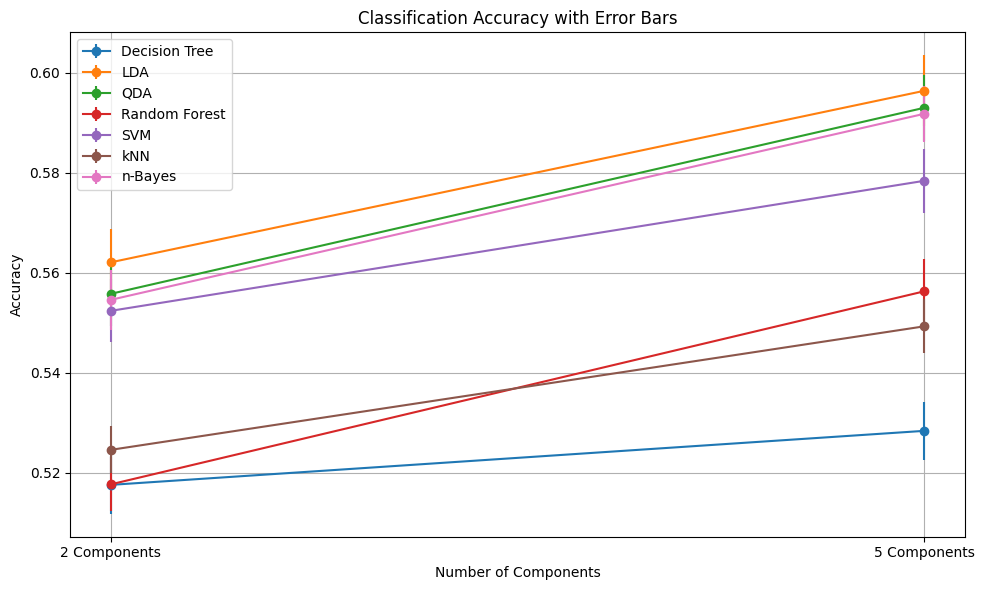

In [17]:
# Plotting the line plot
plt.figure(figsize=(10, 6))

for index, row in formatted_results_df.iterrows():
    plt.errorbar(['2 Components', '5 Components'],
                 [row['Accuracy 2'], row['Accuracy 5']],
                 yerr=[row['Error 2'], row['Error 5']],
                 label=row['Classifier'],
                 fmt='-o')

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy with Error Bars')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# From this the code for the Dataset Starts please chekc from Here

In [18]:
import pandas as pd

# Load the dataset
file_path = 'arrhythmia_main.csv'
data = pd.read_csv(file_path)

# Display basic information about the dataset and the first few rows
data.info(), data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 279 entries, age to class
dtypes: float64(120), int64(159)
memory usage: 985.3 KB


(None,
    age  sex  height  weight  QRSduration  PRinterval  Q-Tinterval  Tinterval  \
 0   75    0     190      80           91         193          371        174   
 1   56    1     165      64           81         174          401        149   
 2   54    0     172      95          138         163          386        185   
 3   55    0     175      94          100         202          380        179   
 4   75    0     190      80           88         181          360        177   
 
    Pinterval  QRS  ...  chV6_QwaveAmp  chV6_RwaveAmp  chV6_SwaveAmp  \
 0        121  -16  ...            0.0            9.0           -0.9   
 1         39   25  ...            0.0            8.5            0.0   
 2        102   96  ...            0.0            9.5           -2.4   
 3        143   28  ...            0.0           12.2           -2.2   
 4        103  -16  ...            0.0           13.1           -3.6   
 
    chV6_RPwaveAmp  chV6_SPwaveAmp  chV6_PwaveAmp  chV6_TwaveAmp  chV6_

In [19]:
data.shape

(452, 279)

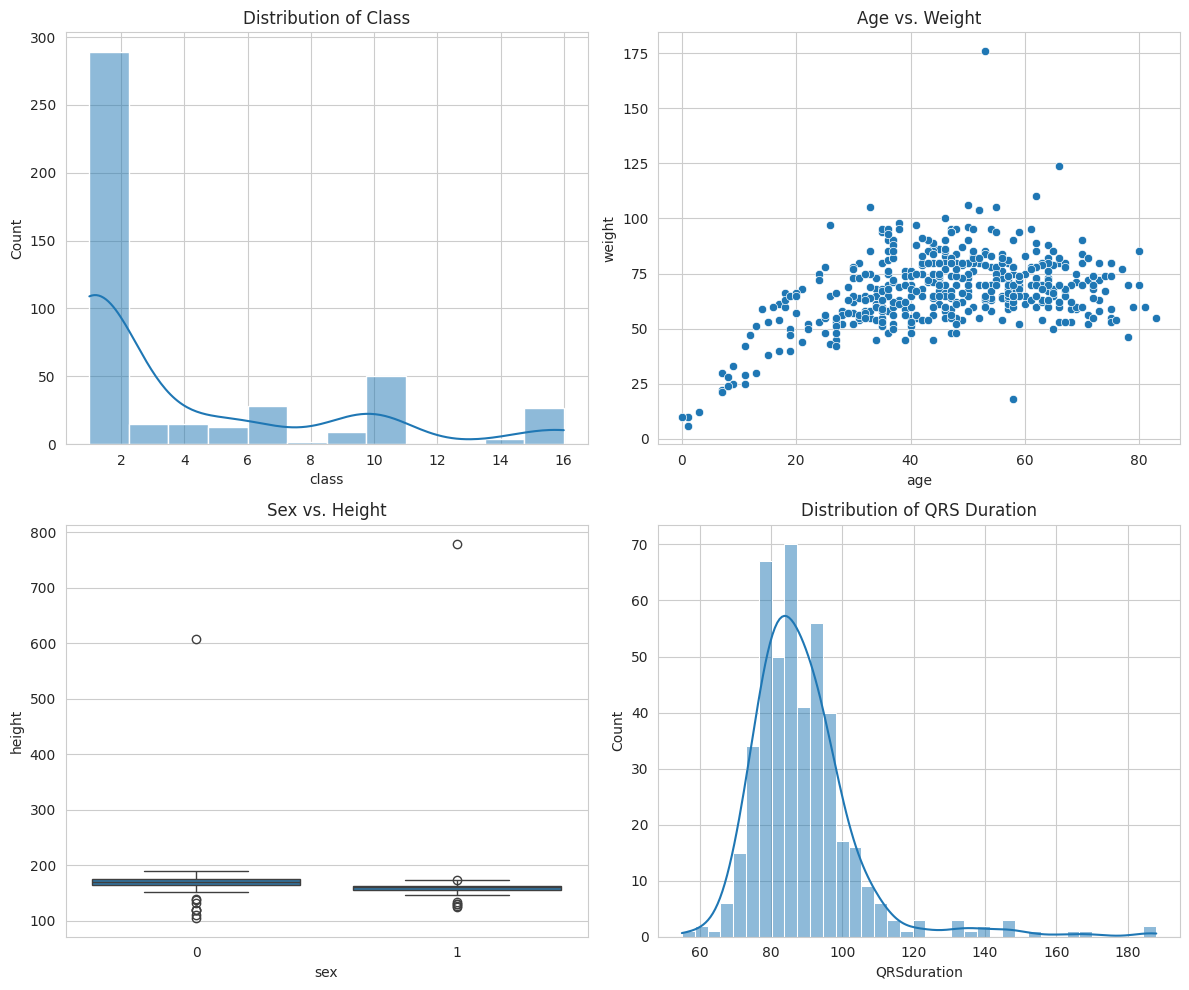

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn plots
sns.set_style('whitegrid')

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Distribution of the 'class' column
sns.histplot(data=data, x='class', kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Class')

# Plot 2: Scatter plot of age vs. weight
sns.scatterplot(data=data, x='age', y='weight', ax=axs[0, 1])
axs[0, 1].set_title('Age vs. Weight')

# Plot 3: Boxplot of sex vs. height
sns.boxplot(data=data, x='sex', y='height', ax=axs[1, 0])
axs[1, 0].set_title('Sex vs. Height')

# Plot 4: Distribution of QRS duration
sns.histplot(data=data, x='QRSduration', kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of QRS Duration')

# Adjust layout
plt.tight_layout()
plt.show()


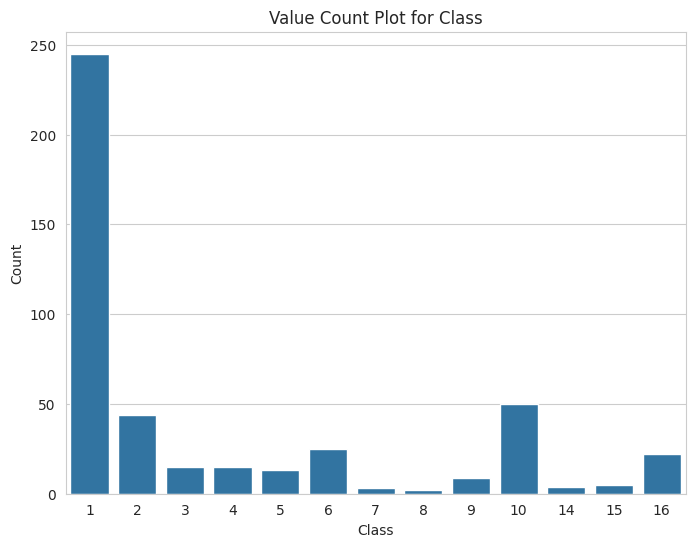

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the value count plot for the 'class' column
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='class')
plt.title('Value Count Plot for Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [22]:
# Check for null values in the dataset
null_counts = data.isnull().sum()
null_counts[null_counts > 0]


T             8
P            22
QRST          1
heartrate     1
dtype: int64

In [23]:
# Check for null values in the dataset
null_counts = data.isnull().sum()
null_counts[null_counts > 0]


T             8
P            22
QRST          1
heartrate     1
dtype: int64

In [24]:
from sklearn import random_projection
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn import datasets
from sklearn import random_projection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.stats import sem
from sklearn.base import BaseEstimator, ClassifierMixin, clone
 # For standard error calculation

In [25]:

# Load the dataset
data = pd.read_csv('/content/arrhythmia_main.csv')

# Handle null values
data.fillna(data.median(), inplace=True)

# Filter classes with very few samples
class_counts = data['class'].value_counts()
filtered_classes = class_counts[class_counts >= 3].index
filtered_data = data[data['class'].isin(filtered_classes)]

# Split the data
X = filtered_data.drop('class', axis=1)
y = filtered_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Define RandomProjectionClassifier
class RandomProjectionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, n_projections=10, n_components='auto', random_state=None):
        self.base_classifier = base_classifier
        self.n_projections = n_projections
        self.n_components = n_components
        self.random_state = random_state
        self.classifiers = []
        self.projections = []

    def fit(self, X, y):
        for _ in range(self.n_projections):
            rp = random_projection.GaussianRandomProjection(n_components=self.n_components, random_state=self.random_state)
            X_proj = rp.fit_transform(X)
            clf = clone(self.base_classifier)
            clf.fit(X_proj, y)
            self.classifiers.append(clf)
            self.projections.append(rp)
        return self

    def predict(self, X):
        predictions = np.array([clf.predict(rp.transform(X)) for clf, rp in zip(self.classifiers, self.projections)])
        majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)
        return majority_vote

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

# Define classifiers
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'kNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'n-Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
}

# Simulation function
def simulate_with_random_projection(X_train, X_test, y_train, y_test, classifier, num_projections, projection_dim):
    accuracies = []
    for _ in range(num_projections):
        transformer = random_projection.GaussianRandomProjection(n_components=projection_dim)
        X_train_new = transformer.fit_transform(X_train)
        X_test_new = transformer.transform(X_test)
        clf = clone(classifier)
        clf.fit(X_train_new, y_train)
        predictions = clf.predict(X_test_new)
        accuracies.append(accuracy_score(y_test, predictions))
    avg_accuracy = np.mean(accuracies)
    std_error = sem(accuracies)
    return avg_accuracy, std_error

# Run the simulation
results = {name: [] for name in classifiers}
projection_dims = [2, 5]  # Adjust dimensions as needed
for name, clf in classifiers.items():
    for dim in projection_dims:
        accuracy, error = simulate_with_random_projection(X_train, X_test, y_train, y_test, clf, 10, dim)
        results[name].append((dim, accuracy, error))

# Display results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['2D Projection', '5D Projection'])
print(results_df)

                                                2D Projection  \
LDA            (2, 0.5577777777777777, 0.0036288736930121155)   
kNN            (2, 0.5333333333333333, 0.0075903339007108075)   
SVM                           (2, 0.55, 0.005555555555555557)   
n-Bayes         (2, 0.5622222222222222, 0.008314794192830982)   
Random Forest   (2, 0.45888888888888896, 0.01453910105658557)   
Decision Tree  (2, 0.37333333333333335, 0.008148148148148147)   

                                               5D Projection  
LDA                          (5, 0.57, 0.010482201257840678)  
kNN            (5, 0.5466666666666666, 0.010579893968211632)  
SVM             (5, 0.5688888888888888, 0.00518518518518518)  
n-Bayes        (5, 0.5655555555555555, 0.010918076276284201)  
Random Forest  (5, 0.5722222222222222, 0.010638078975070419)  
Decision Tree  (5, 0.4188888888888888, 0.022954000640512836)  


In [27]:
# Prepare reduced results for displaying in a DataFrame
reduced_results_formatted = {name: [f"{acc:.2%} ± {err:.2%}" for _, acc, err in values] for name, values in results.items()}
reduced_results_df = pd.DataFrame.from_dict(reduced_results_formatted, orient='index', columns=[f"{dim} components" for dim in projection_dims])
reduced_results_df

,2 components,5 components
LDA,55.78% ± 0.36%,57.00% ± 1.05%
kNN,53.33% ± 0.76%,54.67% ± 1.06%
SVM,55.00% ± 0.56%,56.89% ± 0.52%
n-Bayes,56.22% ± 0.83%,56.56% ± 1.09%
Random Forest,45.89% ± 1.45%,57.22% ± 1.06%
Decision Tree,37.33% ± 0.81%,41.89% ± 2.30%


In [28]:
# Flatten the results to match the desired format
flattened_results = []
for classifier, projections in results.items():
    for dim, accuracy, error in projections:
        flattened_results.append({
            'Dimension': dim,
            'Classifier': classifier,
            'Accuracy': accuracy,
            'Error': error
        })

# Convert to DataFrame
formatted_results_df = pd.DataFrame(flattened_results)
formatted_results_df = formatted_results_df.pivot(index='Classifier', columns='Dimension', values=['Accuracy', 'Error'])
formatted_results_df.columns = [' '.join(map(str, col)).strip() for col in formatted_results_df.columns.values]
formatted_results_df.reset_index(inplace=True)
formatted_results_df = formatted_results_df[['Classifier', 'Accuracy 2', 'Accuracy 5', 'Error 2', 'Error 5']]
formatted_results_df

,Classifier,Accuracy 2,Accuracy 5,Error 2,Error 5
0,Decision Tree,0.373333,0.418889,0.008148,0.022954
1,LDA,0.557778,0.570000,0.003629,0.010482
2,Random Forest,0.458889,0.572222,0.014539,0.010638
3,SVM,0.550000,0.568889,0.005556,0.005185
4,kNN,0.533333,0.546667,0.007590,0.010580
5,n-Bayes,0.562222,0.565556,0.008315,0.010918


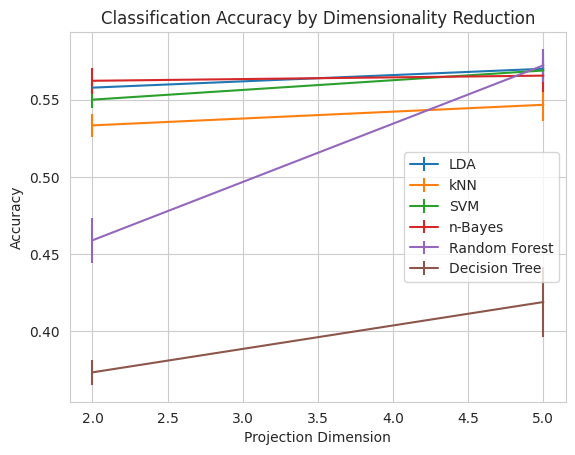

In [29]:
def plot_results(results):
    for name, result in results.items():
        dims, accuracies, errors = zip(*result)
        plt.errorbar(dims, accuracies, yerr=errors, label=name)

    plt.xlabel('Projection Dimension')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy by Dimensionality Reduction')
    plt.legend()
    plt.show()

plot_results(results)


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import random_projection
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import sem
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import pandas as pd

# Define your classifiers here
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'kNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'n-Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    # Add any additional classifiers you want to compare
}

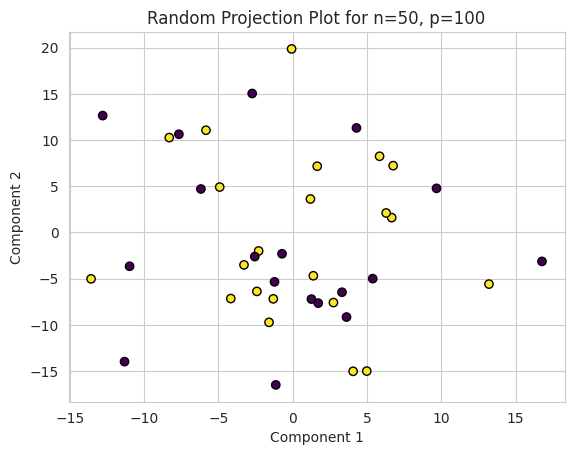

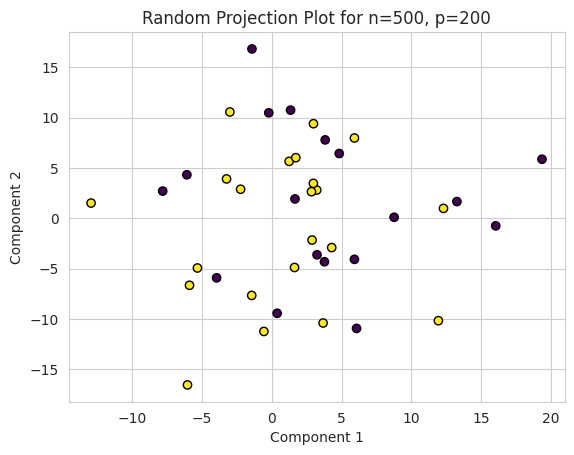

In [35]:
def run_simulations(classifiers, X_train, y_train, X_test, y_test, n_projections, projection_dims):
    results = {}
    for name, clf in classifiers.items():
        results[name] = {}
        for dim in projection_dims:
            rp_clf = RandomProjectionClassifier(clf, n_projections=n_projections, n_components=dim)
            rp_clf.fit(X_train, y_train)
            acc = rp_clf.score(X_test, y_test)
            err = sem([rp_clf.score(X_test, y_test) for _ in range(10)])
            results[name][dim] = (acc, err)
    return results

def run_simulated_data_simulations(classifiers, n_samples, n_features, n_projections, projection_dims):
    X, y = datasets.make_classification(n_samples=n_samples, n_features=n_features, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return run_simulations(classifiers, X_train, y_train, X_test, y_test, n_projections, projection_dims)

# Define a function to plot the projections
def plot_projections(classifier, X_train, y_train, title):
    rp = random_projection.GaussianRandomProjection(n_components=2)
    X_projected = rp.fit_transform(X_train)
    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y_train, cmap='viridis', edgecolor='k')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Simulation parameters
n_projections = 50
projection_dims = [2, 5]
n_samples_list = [50, 500]
n_features_list = [100,200]

# Run simulations for each set of parameters
all_results = {}
for n_samples, n_features in zip(n_samples_list, n_features_list):
    sim_results = run_simulated_data_simulations(classifiers, n_samples, n_features, n_projections, projection_dims)
    all_results[(n_samples, n_features)] = sim_results
    # Plot the projections for the first classifier as an example
    plot_projections(list(classifiers.values())[0], X_train, y_train, f'Random Projection Plot for n={n_samples}, p={n_features}')

# Tabulate results in the specified format
results_table = []
for (n_samples, n_features), results in all_results.items():
    for name, acc_err_dict in results.items():
        for dim, (acc, err) in acc_err_dict.items():
            results_table.append({
                'Classifier': name,
                'n': n_samples,
                'p': n_features,
                'Dimension': dim,
                'Accuracy': f"{acc:.2f}",
                'Error': f"{err:.2f}"
            })



In [37]:
# Simulation function
from sklearn.metrics import accuracy_score, precision_score, recall_score
def run_simulations(classifiers, X_train, y_train, X_test, y_test, projection_dims):
    results = {}
    for name, clf in classifiers.items():
        results[name] = {}
        for dim in projection_dims:
            rp_clf = RandomProjectionClassifier(clf, n_components=dim)
            rp_clf.fit(X_train, y_train)
            y_pred = rp_clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            results[name][dim] = {'Accuracy': acc, 'Precision': prec, 'Recall': recall}
    return results

# Simulate data and run simulations
n_projections = 50
projection_dims = [2, 5]
n_samples_list = [50, 300]
n_features_list = [100, 200,300]
all_results = {}

for n_samples, n_features in zip(n_samples_list, n_features_list):
    X, y = datasets.make_classification(n_samples=n_samples, n_features=n_features, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    sim_results = run_simulations(classifiers, X_train, y_train, X_test, y_test, projection_dims)
    all_results[(n_samples, n_features)] = sim_results

# Compile results into a table
results_table = []
for (n_samples, n_features), results in all_results.items():
    for name, metrics in results.items():
        for dim, values in metrics.items():
            results_table.append({
                'Classifier': name,
                'n': n_samples,
                'p': n_features,
                'Dimension': dim,
                'Accuracy': f"{values['Accuracy']:.2f}",
                'Precision': f"{values['Precision']:.2f}",
                'Recall': f"{values['Recall']:.2f}"
            })

# Convert results table to DataFrame and pivot for display
df_results = pd.DataFrame(results_table)
pivot_df = df_results.pivot_table(values=['Accuracy', 'Precision', 'Recall'], index=['Classifier', 'n', 'p'], columns='Dimension', aggfunc=lambda x: x)
pivot_df

Accuracy       Precision       Recall      
Dimension                    2     5         2     5      2     5
Classifier    n   p                                              
Decision Tree 50  100     0.40  0.60      0.48  0.60   0.48  0.62
              300 200     0.53  0.47      0.54  0.48   0.54  0.48
LDA           50  100     0.50  0.90      0.69  0.88   0.64  0.93
              300 200     0.53  0.73      0.60  0.74   0.59  0.75
QDA           50  100     0.50  0.50      0.69  0.46   0.64  0.45
              300 200     0.57  0.73      0.64  0.75   0.62  0.76
Random Forest 50  100     0.40  0.70      0.40  0.67   0.38  0.69
              300 200     0.55  0.52      0.56  0.52   0.56  0.52
SVM           50  100     0.40  0.60      0.67  0.60   0.57  0.62
              300 200     0.58  0.52      0.64  0.55   0.63  0.55
kNN           50  100     0.90  0.80      0.88  0.80   0.93  0.86
              300 200     0.52  0.62      0.51  0.62   0.51  0.63
n-Bayes       50  100     0.30  0.70      0.38  0.75   0.40  0.79
              300 200     0.57  0.63      0.60  0.67   0.60  0.67

# WILL PLOT THE RESULTS TOO

# #  Integrate the ensemble classifier formulation

In [ ]:
print(np.bincount(y))


[  0 245  44  15  15  13  25   3   0   9  50   0   0   0   4   5  22]


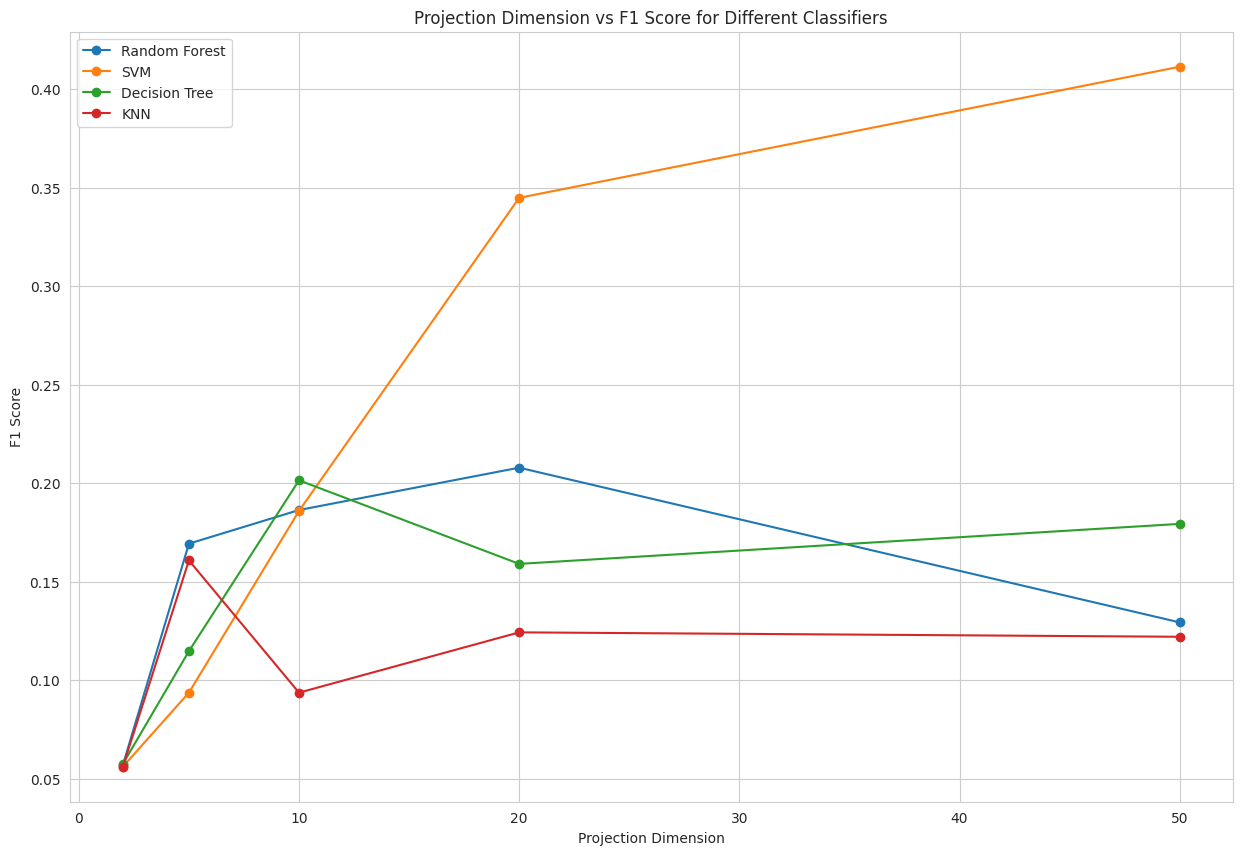

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.random_projection import GaussianRandomProjection
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv('/content/arrhythmia_main.csv')  # Replace with your file path

# Handle missing values
imputer = SimpleImputer(strategy='median')
X = data.drop('class', axis=1)
y = data['class']
X_imputed = imputer.fit_transform(X)

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define four base classifiers for evaluation
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Setting up the random projection ensemble
class RandomProjectionEnsemble:
    def __init__(self, base_classifier, n_projections=10, n_components=2):
        self.base_classifier = base_classifier
        self.n_projections = n_projections
        self.n_components = n_components
        self.classifiers = []
        self.projections = []

    def fit(self, X, y):
        self.classifiers = []  # Reset the classifiers list
        self.projections = []  # Reset the projections list
        for _ in range(self.n_projections):
            rp = GaussianRandomProjection(n_components=self.n_components)
            X_projected = rp.fit_transform(X)
            clf = clone(self.base_classifier)
            clf.fit(X_projected, y)
            self.classifiers.append(clf)
            self.projections.append(rp)

    def predict(self, X):
        # Aggregate predictions from all classifiers
        predictions = np.array([clf.predict(rp.transform(X)) for rp, clf in zip(self.projections, self.classifiers)])
        # Majority vote
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x, minlength=y.max() + 1).argmax(), 0, predictions)
        return majority_vote

# Function to calculate F1 scores for each classifier and projection dimension
def calculate_f1_scores(X_train, y_train, X_test, y_test, classifiers, n_components_list):
    results = {}
    for name, clf in classifiers.items():
        f1_scores = []
        for n_components in n_components_list:
            ensemble = RandomProjectionEnsemble(clf, n_projections=10, n_components=n_components)
            ensemble.fit(X_train, y_train)
            y_pred = ensemble.predict(X_test)
            f1 = f1_score(y_test, y_pred, average='macro')
            f1_scores.append(f1)
        results[name] = f1_scores
    return results

# Define the projection dimensions to test
n_components_list = [2, 5, 10, 20, 50]

# Calculate F1 scores for the selected classifiers and projection dimensions
f1_results = calculate_f1_scores(X_train, y_train, X_test, y_test, classifiers, n_components_list)

# Plotting the F1 Scores
plt.figure(figsize=(15, 10))
for name, f1 in f1_results.items():
    plt.plot(n_components_list, f1, marker='o', label=name)
plt.title('Projection Dimension vs F1 Score for Different Classifiers')
plt.xlabel('Projection Dimension')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('projection_dimension_vs_f1.png')  # This will save the plot as a PNG image
plt.show()


In [ ]:
f1_results

{'Random Forest': [0.05693069306930693,
  0.1693171049514333,
  0.1863876863876864,
  0.20787981859410434,
  0.12935439876433666],
 'SVM': [0.05609756097560975,
  0.09368728334245575,
  0.18594276094276097,
  0.344849836154184,
  0.4113942121564073],
 'Decision Tree': [0.0575,
  0.11475812547241121,
  0.20146298146298144,
  0.15905017921146952,
  0.17935197257231153],
 'KNN': [0.05609756097560975,
  0.1608169129720854,
  0.09368728334245575,
  0.1242989417989418,
  0.12205387205387207]}

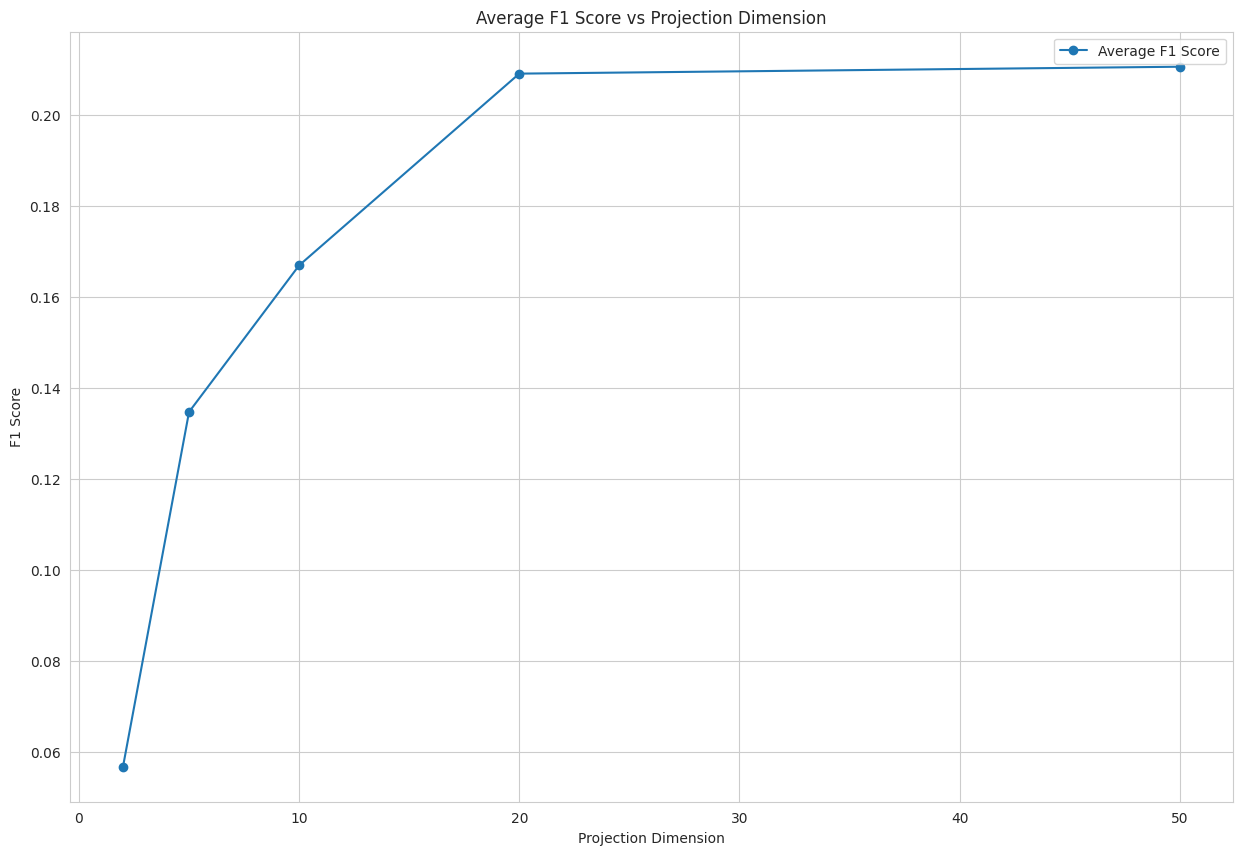

In [ ]:
import matplotlib.pyplot as plt
# Calculate the average F1 score for each projection dimension
average_f1_scores = []
for i in range(len(n_components_list)):
    mean_f1 = np.mean([f1_results[clf][i] for clf in f1_results])
    average_f1_scores.append(mean_f1)

# Plotting the average F1 Scores
plt.figure(figsize=(15, 10))
plt.plot(n_components_list, average_f1_scores, marker='o', label='Average F1 Score')
plt.title('Average F1 Score vs Projection Dimension')
plt.xlabel('Projection Dimension')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()
